<a href="https://colab.research.google.com/github/hrishipoola/Purchase_Patterns_Metrics_Churn_Risk/blob/main/Purchase_Patterns%2C_Metrics%2C_%26_Churn_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents
1. Introduction
2. Install & Import Packages
3. Load Data
4. Detect & Treat Outliers (Tukey's, Winsorize)
5. Time Series Trends
6. Low Price Transactions
7. Pareto
8. New & Returning Customers
9. Metrics
10. Churn Risk
11. References

## 1. Introduction

Today, we'll work with the retail transactions [data we cleaned and processed in a previous post](https://crawstat.com/2021/03/16/product-focus-recs-using-pareto-apriori-association/). After detecting and treating outliers using Tukey's method and winsorization, we'll uncover purchase patterns across different time slices and define Pareto - or the 20% of products and customers driving 80% of sales. We'll compare new and returning customers, which we'll define as first-time purchasers and customers purchasing again within a month, respectively. Classifying new and returning customers helps us understand how customer acquisition and retention rates change over time and how purchase habits, like average order value (AOV), compares between the two groups. 

We'll then create a dataframe of juicy metrics, including recency, frequency, monetary value (RFM), average and total quantity, AOV, and 90th and 50th percentile of days-between-purchase by customer. While we we'll use only a few of them for the purpose of classifying churn risk, let's save and keep them handy for future modeling. If you're interested in learning more on RFM, check out our previous post on [RFM metrics and segmentation / clustering](https://crawstat.com/2021/03/03/customer-rfmt-metrics-segmentation/). 

Lastly, we'll define churn risk by customer. Since we're working with retail ecommerce data, the type of churn is voluntary, continuous, and non-contractual. We'll define a function to identify high, medium, and low churn risk by customer. We'll also visualize purchase differences by churn risk. Based on customers classified as high risk of churn, we'll see that £828337.83 in revenue is at high risk of being lost. Classifying churn risk allows us to allocate resources where they're needed most. For example, we can intensify sales, mareting, and product activities aimed at high risk churn customers in order to retain them. 

## 2. Install & Import Packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date, timedelta
from datetime import date

from scipy.stats.mstats import winsorize
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
sns.set_style("darkgrid")
style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm 

import io
from io import BytesIO
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mount google drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
uploaded = files.upload()

Saving online_retail_processed.csv.gz to online_retail_processed.csv.gz


## 3. Load Data

In [4]:
df = pd.read_csv('online_retail_processed.csv.gz', compression='gzip', parse_dates=['InvoiceDate'])
df.drop(['Holiday', 'Date'], axis=1, inplace=True)
df['InvoiceMonth'] = df.InvoiceDate.dt.strftime("%Y-%m") # Column for cohort, format Year-Month
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,TotalPrice,Year,Month,Day,DayName,Hour,InvoiceMonth
0,536365,85123A,6,2010-12-01 08:26:00,2.95,17850,UNITED KINGDOM,CREAM HANGING HEART T-LIGHT HOLDER,17.7,2010,12,1,Wednesday,8,2010-12
1,536365,71053,6,2010-12-01 08:26:00,3.75,17850,UNITED KINGDOM,WHITE METAL LANTERN,22.5,2010,12,1,Wednesday,8,2010-12
2,536365,84406B,8,2010-12-01 08:26:00,4.15,17850,UNITED KINGDOM,CREAM CUPID HEARTS COAT HANGER,33.2,2010,12,1,Wednesday,8,2010-12
3,536365,84029G,6,2010-12-01 08:26:00,4.25,17850,UNITED KINGDOM,KNITTED UNION FLAG HOT WATER BOTTLE,25.5,2010,12,1,Wednesday,8,2010-12
4,536365,84029E,6,2010-12-01 08:26:00,4.25,17850,UNITED KINGDOM,RED WOOLLY HOTTIE WHITE HEART,25.5,2010,12,1,Wednesday,8,2010-12


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396036 entries, 0 to 396035
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     396036 non-null  int64         
 1   StockCode     396036 non-null  object        
 2   Quantity      396036 non-null  int64         
 3   InvoiceDate   396036 non-null  datetime64[ns]
 4   UnitPrice     396036 non-null  float64       
 5   CustomerID    396036 non-null  int64         
 6   Country       396036 non-null  object        
 7   Description   396036 non-null  object        
 8   TotalPrice    396036 non-null  float64       
 9   Year          396036 non-null  int64         
 10  Month         396036 non-null  int64         
 11  Day           396036 non-null  int64         
 12  DayName       396036 non-null  object        
 13  Hour          396036 non-null  int64         
 14  InvoiceMonth  396036 non-null  object        
dtypes: datetime64[ns]

In [6]:
print('Dates range from {} to {}.'.format(min(df.InvoiceDate.dt.date), max(df.InvoiceDate.dt.date)))

Dates range from 2010-12-01 to 2011-12-09.


Let's keep only months with a full-month of transactions data.

In [7]:
df = df[(df.InvoiceDate >= '2010-12-01') & (df.InvoiceDate < '2011-12-01')]
df.reset_index(inplace=True, drop=True)
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID,TotalPrice,Year,Month,Day,Hour
count,378794.000000,378794.000000,378794.000000,378794.000000,378794.000000,378794.000000,378794.000000,378794.000000,378794.000000
mean,559704.183305,12.852920,2.875020,15301.832848,23.402802,2010.931213,7.414336,15.492017,12.714887
std,12666.023264,127.981629,3.832597,1709.215894,172.902089,0.253091,3.360766,8.558939,2.263412
min,536365.000000,1.000000,0.040000,12346.000000,0.060000,2010.000000,1.000000,1.000000,6.000000
25%,548632.000000,2.000000,1.250000,13975.000000,4.560000,2011.000000,5.000000,8.000000,11.000000
50%,560828.000000,6.000000,1.950000,15179.000000,11.800000,2011.000000,8.000000,15.000000,13.000000
75%,570857.000000,12.000000,3.750000,16800.000000,19.800000,2011.000000,10.000000,23.000000,14.000000
max,579885.000000,74215.000000,165.000000,18287.000000,92768.750000,2011.000000,12.000000,31.000000,20.000000


## 4. Detect & Treat Outliers

Let's detect and treat outliers so they won't skew our understanding of time series trends and models. 

We'll focus on unusual purchase quantities. Because outlier quantity values also contain useful information, rather than simply deleting them, we'll moderate their impact. 

### Quantity

#### Detect

In [8]:
df.sort_values('Quantity', ascending=False).head(5)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,TotalPrice,Year,Month,Day,DayName,Hour,InvoiceMonth
36974,541431,23166,74215,2011-01-18 10:01:00,1.25,12346,UNITED KINGDOM,MEDIUM CERAMIC TOP STORAGE JAR,92768.75,2011,1,18,Tuesday,10,2011-01
306573,573008,84077,4800,2011-10-27 12:26:00,0.29,12901,UNITED KINGDOM,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1392.00,2011,10,27,Thursday,12,2011-10
142578,554868,22197,4300,2011-05-27 10:52:00,0.85,13135,UNITED KINGDOM,POPCORN HOLDER,3655.00,2011,5,27,Friday,10,2011-05
61329,544612,22053,3906,2011-02-22 10:43:00,1.25,18087,UNITED KINGDOM,EMPIRE DESIGN ROSETTE,4882.50,2011,2,22,Tuesday,10,2011-02
187918,560599,18007,3186,2011-07-19 17:04:00,0.18,14609,UNITED KINGDOM,ESSENTIAL BALM 35G TIN IN ENVELOPE,573.48,2011,7,19,Tuesday,17,2011-07


Text(0, 0.5, '£')

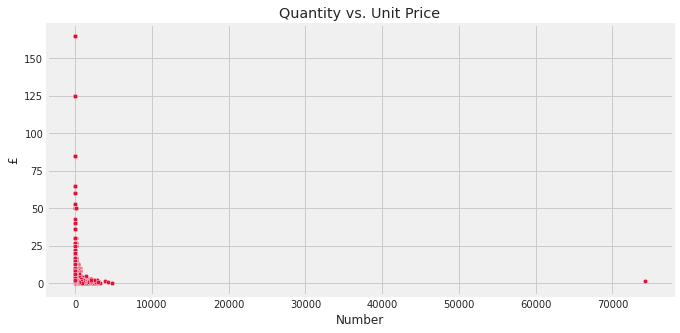

In [9]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='Quantity', y='UnitPrice', data=df, color='crimson', s=20)
plt.title('Quantity vs. Unit Price')
plt.xlabel('Number')
plt.ylabel('£')

Text(0.5, 0, 'Number')

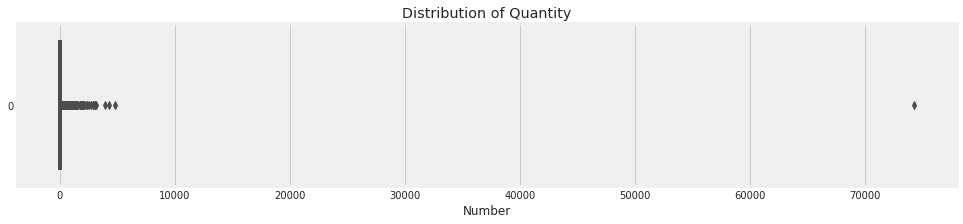

In [10]:
plt.figure(figsize=(15,3))
sns.boxplot(data=df['Quantity'], orient='h', color='slategray')
plt.title('Distribution of Quantity')
plt.xlabel('Number')

Text(0.5, 6.800000000000001, 'Number')

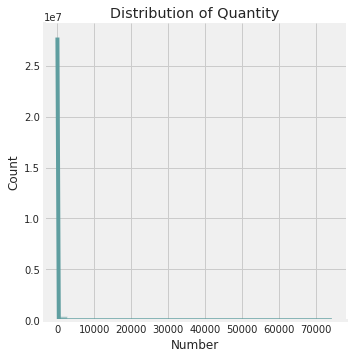

In [11]:
# Plot distribution
sns.displot(df['Quantity'],bins=30, kde=True, color='cadetblue')
plt.title('Distribution of Quantity')
plt.xlabel('Number')

#### Tukey's Method

Tukey's method generates possible and probable outliers by constructing inner and outer fences based on IQR. The lower inner fence is 1.5 x IQR below Q1, while the upper inner fence is 1.5 x IQR above Q3. The lower outer fence is 3 x IQR below Q1, while the upper outer fence is 3 x IQR above Q3. Possible outliers lie between the inner and outer fence, while probable outliers lie outside the outer fence. We care about treating the probable outliers. Tukey's method is robust to outliers and doesn't require a normal distribution. Additionally, for right-skewed data, we can still apply Tukey's method on log transformed variables. 

In [12]:
# Create function for tukey's method
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1 - inner_fence
    inner_fence_ue = q3 + inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1 - outer_fence
    outer_fence_ue = q3 + outer_fence
    
    outliers_probable = []
    outliers_possible = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_probable.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_possible.append(index)
    return outliers_probable, outliers_possible, outer_fence_le, outer_fence_ue
        
probable_outliers_tm, possible_outliers_tm, outer_fence_lower, outer_fence_upper  = tukeys_method(df, 'Quantity')
print('Number of probable outliers:', len(probable_outliers_tm))
print('Number of possible outliers:', len(possible_outliers_tm))
print('Lower outer fence:', outer_fence_lower)
print('Upper outer fence:', outer_fence_upper)

Number of probable outliers: 17806
Number of possible outliers: 24595
Lower outer fence: -28.0
Upper outer fence: 42.0


#### Treat

#### Winsorize

Winsorizing replaces all values beyond a k percentile with the k percentile value, which is less extreme than simply removing these values. Piggybacking from the tukey method, the k percentile will be set at the distribution's outer fence. 

The quantity variable's upper outer fence is 42, which is in between the 95% (36) and 97.5% (72), so let's set the upper bound for winsorization in the middle to 96%. For the lower bound, a quantity below zero doesn't make sense, so we'll set the lower bound to 0 and the data will only be right-tail winsorized.  

In [13]:
print('Lower outer fence: ', outer_fence_lower)
print('Upper outer fence: ', outer_fence_upper)

Lower outer fence:  -28.0
Upper outer fence:  42.0


In [14]:
percentiles = [0.90, 0.925, 0.95, 0.975, 0.99, 0.999]
for percentile in percentiles:
  print('{}% quantile: {}'.format(percentile*100, df['Quantity'].quantile(percentile)))

90.0% quantile: 24.0
92.5% quantile: 25.0
95.0% quantile: 36.0
97.5% quantile: 72.0
99.0% quantile: 120.0
99.9% quantile: 504.0


Text(0.5, 1.0, 'Distribution of Winsorized Quantity')

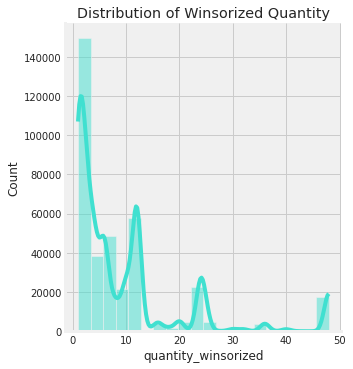

In [15]:
# Winsorize
df['quantity_winsorized'] = winsorize(df['Quantity'], limits=[0, 0.04])

# Plot distribution
sns.displot(df['quantity_winsorized'],bins=20, kde=True, color='turquoise')
plt.title('Distribution of Winsorized Quantity')

### Price

#### Detect

Text(0.5, 0, '£')

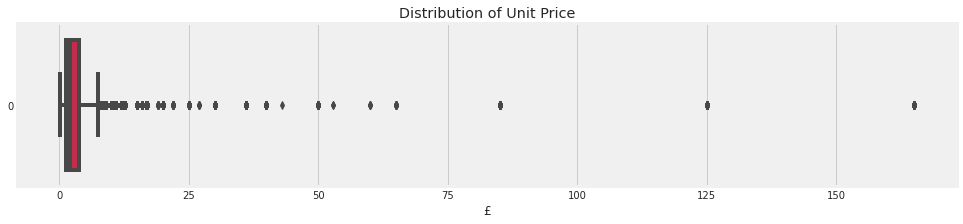

In [16]:
plt.figure(figsize=(15,3))
sns.boxplot(data=df['UnitPrice'], orient='h', color='crimson')
plt.title('Distribution of Unit Price')
plt.xlabel('£')

Text(0.5, 6.800000000000001, '£')

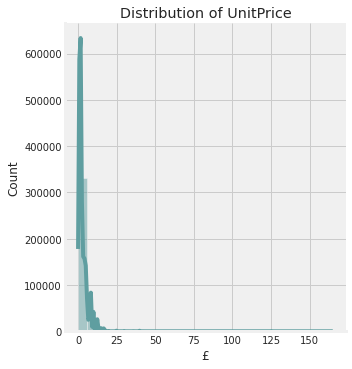

In [17]:
# Plot distribution
sns.displot(df['UnitPrice'],bins=30, kde=True, color='cadetblue')
plt.title('Distribution of UnitPrice')
plt.xlabel('£')

In [18]:
probable_outliers_tm, possible_outliers_tm, outer_fence_lower, outer_fence_upper  = tukeys_method(df, 'UnitPrice')
print('Number of probable outliers:', len(probable_outliers_tm))
print('Number of possible outliers:', len(possible_outliers_tm))
print('Lower outer fence:', outer_fence_lower)
print('Upper outer fence:', outer_fence_upper)

Number of probable outliers: 8366
Number of possible outliers: 33766
Lower outer fence: -6.25
Upper outer fence: 11.25


#### Treat

#### Winsorize

In [19]:
print('Lower outer fence: ', outer_fence_lower)
print('Upper outer fence: ', outer_fence_upper)

Lower outer fence:  -6.25
Upper outer fence:  11.25


In [20]:
percentiles = [0.90, 0.925, 0.95, 0.975, 0.99, 0.999]
for percentile in percentiles:
  print('{}% quantile: {}'.format(percentile*100, df['UnitPrice'].quantile(percentile)))

90.0% quantile: 6.25
92.5% quantile: 7.950000000000001
95.0% quantile: 8.5
97.5% quantile: 9.95
99.0% quantile: 12.75
99.9% quantile: 35.95


The price variable's upper outer fence is 11.25, which is in between the 97.5% (9.95) and 99% (12.75), so let's set the upper bound for winsorization in the middle to 98%. For the lower bound, a price below zero doesn't make sense, so we'll set the lower bound to 0 and the data will only be right-tail winsorized.  

Text(0.5, 1.0, 'Distribution of Winsorized Price')

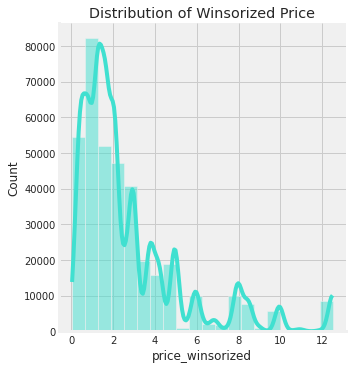

In [21]:
# Winsorize
df['price_winsorized'] = winsorize(df['UnitPrice'], limits=[0, 0.02])

# Plot distribution
sns.displot(df['price_winsorized'],bins=20, kde=True, color='turquoise')
plt.title('Distribution of Winsorized Price')

In [22]:
df.drop(['Quantity', 'UnitPrice'], axis=1, inplace=True)
df['TotalPrice'] = df['quantity_winsorized'] * df['price_winsorized']
df.rename(columns={'quantity_winsorized': 'Quantity', 'price_winsorized': 'UnitPrice'}, inplace=True)
df.describe()

,InvoiceNo,CustomerID,TotalPrice,Year,Month,Day,Hour,Quantity,UnitPrice
count,378794.000000,378794.000000,378794.000000,378794.000000,378794.000000,378794.000000,378794.000000,378794.000000,378794.000000
mean,559704.183305,15301.832848,17.968011,2010.931213,7.414336,15.492017,12.714887,9.477983,2.773602
std,12666.023264,1709.215894,29.141791,0.253091,3.360766,8.558939,2.263412,11.332640,2.624462
min,536365.000000,12346.000000,0.060000,2010.000000,1.000000,1.000000,6.000000,1.000000,0.040000
25%,548632.000000,13975.000000,4.560000,2011.000000,5.000000,8.000000,11.000000,2.000000,1.250000
50%,560828.000000,15179.000000,11.700000,2011.000000,8.000000,15.000000,13.000000,6.000000,1.950000
75%,570857.000000,16800.000000,19.800000,2011.000000,10.000000,23.000000,14.000000,12.000000,3.750000
max,579885.000000,18287.000000,600.000000,2011.000000,12.000000,31.000000,20.000000,48.000000,12.500000


After removing high-end outliers, our max Quantity is 48 and mean is slightly lower at 9.47 while max UnitPrice is 12.50 and mean is lower at 2.77. We also see that our max TotalPrice (sales) is 600. 

Text(0.5, 1.0, 'Distribution of Sales')

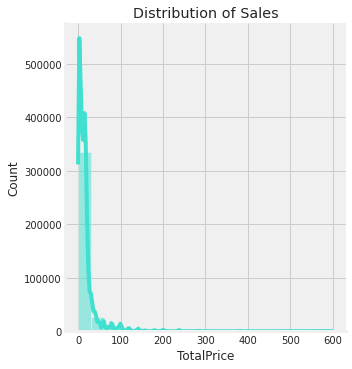

In [23]:
# Plot distribution
sns.displot(df['TotalPrice'],bins=20, kde=True, color='turquoise')
plt.title('Distribution of Sales')

In [24]:
# Save processed data to csv (df is too large so I zipped it)
df.to_csv('online_retail_outliers_removed.csv.gz', compression='gzip', date_format = '%Y-%m-%d %H:%M', index=False)

## 5. Time Series Trends

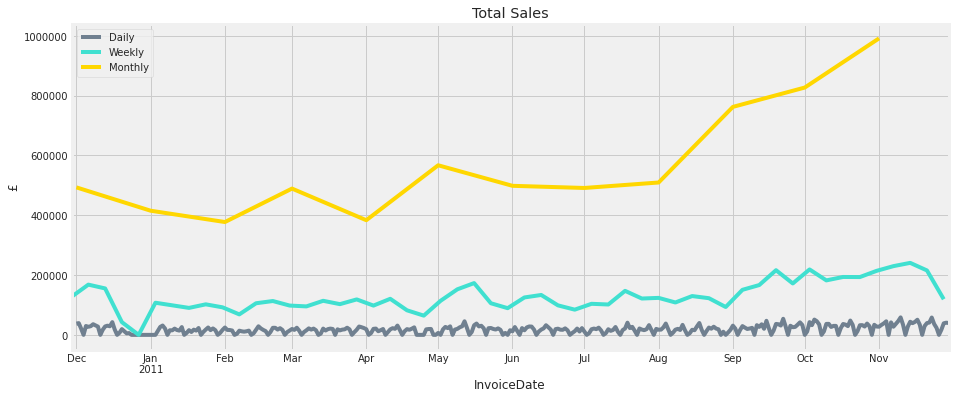

In [25]:
sales = df.groupby(['InvoiceDate'])['TotalPrice'].sum()
sales.index = pd.to_datetime(sales.index)
sales.resample('1D').sum().plot(figsize=(14,6), color='slategray')
sales.resample('1W').sum().plot(figsize=(14,6), color='turquoise')
sales.resample('1M').sum().plot(figsize=(14,6), color='gold')
plt.title('Total Sales')
plt.ylabel('£')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(loc='upper left', labels=['Daily','Weekly','Monthly'])

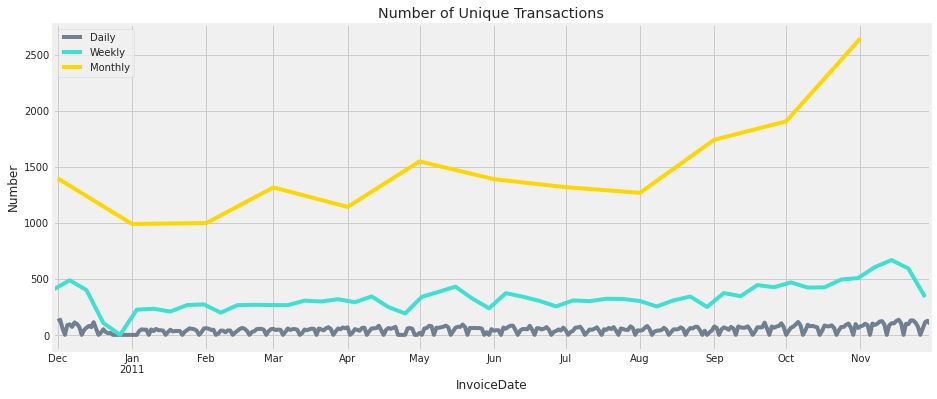

In [26]:
transactions = df.groupby(['InvoiceDate'])['InvoiceNo'].nunique()
transactions.index = pd.to_datetime(transactions.index)
transactions.resample('1D').sum().plot(figsize=(14,6), color='slategray')
transactions.resample('1W').sum().plot(figsize=(14,6), color='turquoise')
transactions.resample('1M').sum().plot(figsize=(14,6), color='gold')
plt.title('Number of Unique Transactions')
plt.ylabel('Number')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(loc='upper left', labels=['Daily','Weekly','Monthly'])

Text(0.5, 1.0, 'Hourly Purchases')

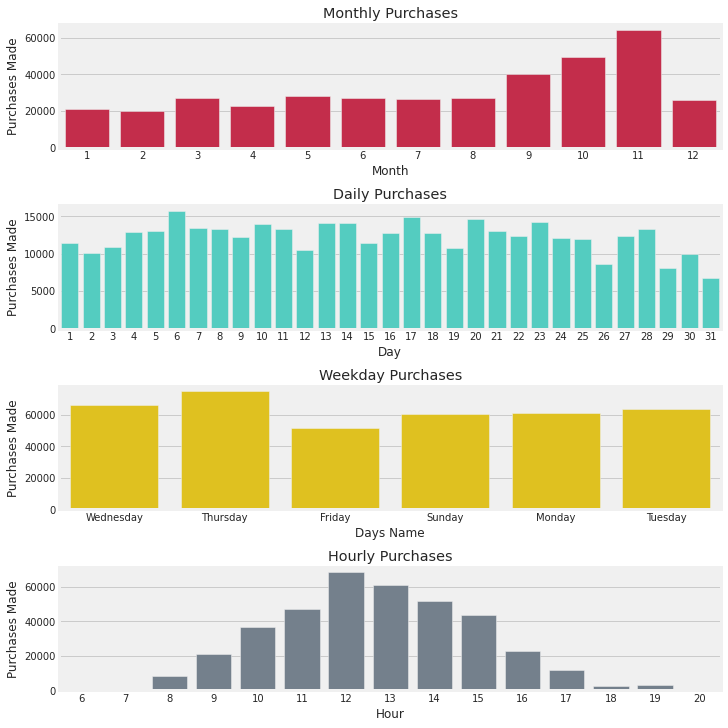

In [27]:
fig, ax = plt.subplots(4,1, constrained_layout = True, figsize=(10,10))
sns.countplot(df[['InvoiceNo','Month']].Month, color ='crimson', ax=ax[0])
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Purchases Made')
ax[0].set_title('Monthly Purchases')

sns.countplot(df[['InvoiceNo','Day']].Day, color ='turquoise', ax=ax[1])
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Purchases Made')
ax[1].set_title('Daily Purchases')

sns.countplot(df[['InvoiceNo','DayName']].DayName, color ='gold', ax=ax[2])
ax[2].set_xlabel('Days Name')
ax[2].set_ylabel('Purchases Made')
ax[2].set_title('Weekday Purchases')

sns.countplot(df[['InvoiceNo','Hour']].Hour, color ='slategray', ax=ax[3])
ax[3].set_xlabel('Hour')
ax[3].set_ylabel('Purchases Made')
ax[3].set_title('Hourly Purchases')

- Purchases peak in October, November
- No clear purchase patterns for days of the month, though purchases seem to be higher in the first 10 days
- Purchases are highest on Wednesdays and Thursdays, lowest on Fridays. There are no purchases on Saturdays, which may be due to the fact that many customers are wholesalers not operating on Saturdays. 
- Purhcases are only made between 8 AM and 7 PM , which means customers may have regular working business hours. Purchases are highest at noon and 1 PM. 

Text(0.5, 0, '£')

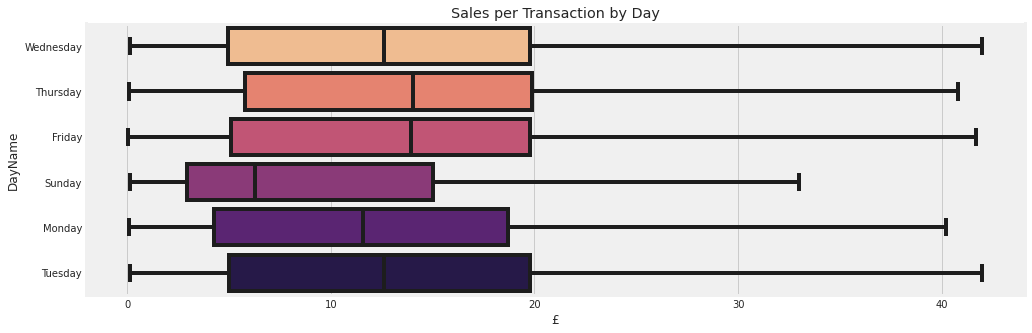

In [28]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x='TotalPrice', y='DayName', showfliers=False, orient='h', palette='magma_r')
plt.title('Sales per Transaction by Day')
plt.xlabel('£')

Mean and spread of sales per transaction is lower on Sunday than other days. Median sales per transaction is highest on Thursday and Friday.

Text(0.5, 0, '£')

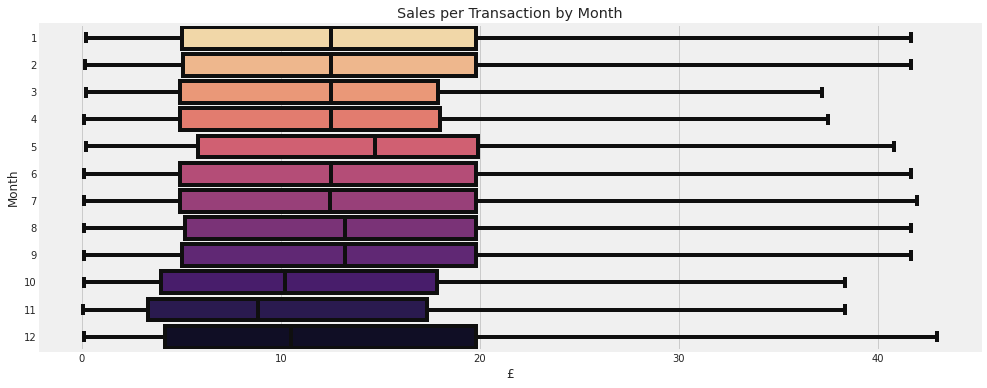

In [29]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df, x='TotalPrice', y='Month', orient='h', showfliers=False, palette='magma_r')
plt.title('Sales per Transaction by Month')
plt.xlabel('£')

Text(0, 0.5, 'Number')

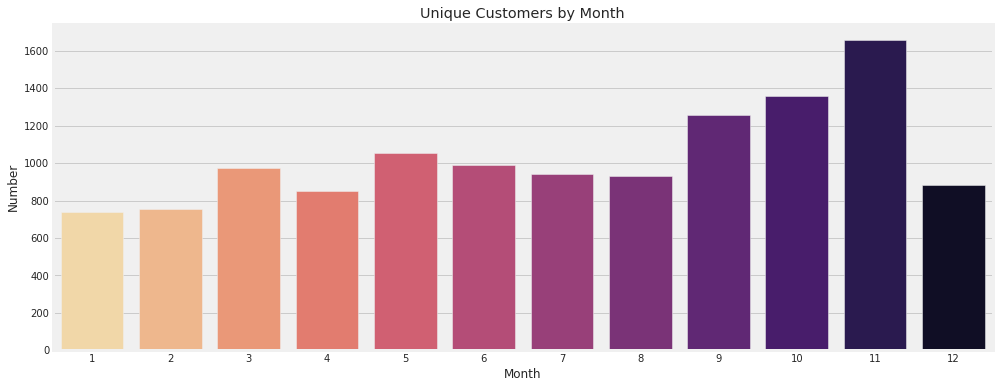

In [30]:
transactions_month = df.groupby(['Month'], as_index=False)['CustomerID'].nunique()
plt.figure(figsize=(15,6))
sns.barplot(data=transactions_month, x='Month', y='CustomerID', palette='magma_r')
plt.title('Unique Customers by Month')
plt.xlabel('Month')
plt.ylabel('Number')

Interestingly, the boxplot reveals that November sees the lowest median sales per transaction, but, as we saw earlier, November sees the highest number of purchases. Additionally, above, we see that November also sees the highest number of unique customers. 

## 6. Low Price Transactions

In [31]:
low_price_transactions = len(df[df.UnitPrice <= 5])/len(df.UnitPrice)*100
print("{:.2f} % of transactions were for items 5 pounds or less.".format(low_price_transactions))

87.35 % of transactions were for items 5 pounds or less.


In [32]:
low_price_sales = df[df.UnitPrice<=5].TotalPrice.sum()/df.TotalPrice.sum()*100
print("{:.2f} % of total sales come from items priced 5 pounds or less.".format(low_price_sales))

76.99 % of total sales come from items priced 5 pounds or less.


## 7. Pareto

Let's create a function for Pareto, or the 80/20 rule, in which roughly 80% of effects come from 20% of the causes (e.g., 20% of products generate 80% of sales). Pareto can help us understand and focus on the core group of products or customers that generate the vast majority of sales. 

In [33]:
def pareto(df, variable_20_percent, measure):
    '''
    # Returns contribution of 20% of a cause variable to 80% of sales
    df: dataset 
    variable_20_percent: column to be checked for 20% of its unique entries to affect 80% of sales
    measure: string - the measure that is conributing to 80%
    '''
    pareto_df = df.groupby(variable_20_percent, as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice', ascending=False)
    pareto_df['Cumulative_Percentage'] = round(pareto_df['TotalPrice'].cumsum() / pareto_df['TotalPrice'].sum()*100,2)

    # Number of products that make up 80% of sales
    percent_80 = pareto_df[pareto_df['Cumulative_Percentage'] <= 80]
    item_num = percent_80[variable_20_percent].nunique()
    item_percent = round(item_num / df[variable_20_percent].nunique()*100,2)

    print(item_percent, '% of', measure, 'generated 80% of sales') 
    print(item_percent,'% means', item_num, measure)

In [34]:
pareto(df, 'Description', 'products')

23.28 % of products generated 80% of sales
23.28 % means 844 products


In [35]:
pareto(df, 'CustomerID', 'customers')

30.29 % of customers generated 80% of sales
30.29 % means 1299 customers


## 8. New & Returning Customers

Let's compare new and returning customers, which we'll define as first-time purchasers and customers purchasing again withing a month, respectively. Classifying new and returning customers helps us understand customer acquisition and retention rate and how they change over time. We'll also compare how average order value (AOV), or the average amount a customer spends per order, compares between new and repeat customers.  

Text(0.5, 1.0, 'Customer Retention Rate vs Customer Acquisition Rate')

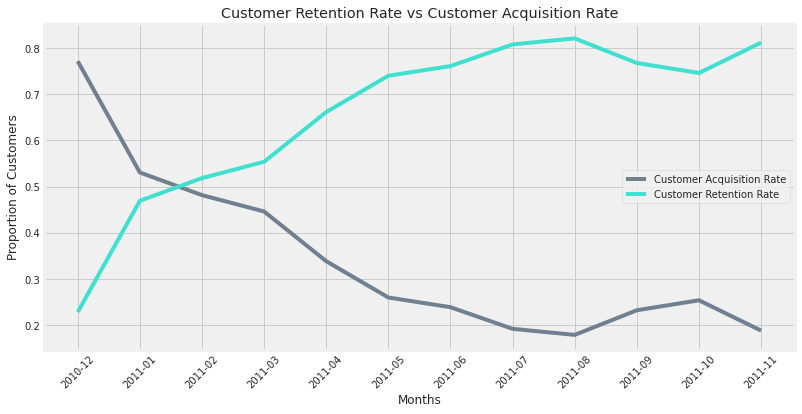

In [36]:
# Classify as returning if purchase again within a month, new as first time purchasers 
df_cust_type = df.drop_duplicates(['InvoiceNo','CustomerID'])
df_cust_type.reset_index(drop=True, inplace=True)
df_cust_type['Type'] = np.nan

for customer in df_cust_type['CustomerID'].unique():
    df_cust_type.loc[df_cust_type[df_cust_type['CustomerID'] == customer].index,'Type'] = 'Repeat'
    df_cust_type.loc[df_cust_type[df_cust_type['CustomerID'] == customer].index[0],'Type'] = 'New'

# Creating a dataframe from dictionary of monthly new and repeat customers
time = {}
for month in df_cust_type['InvoiceMonth'].unique():
    time[month] = (df_cust_type[df_cust_type['InvoiceMonth'] == month].drop_duplicates(['CustomerID','Type'])['Type'].value_counts())

monthly_cust = pd.DataFrame(time).T

# Plot monthly new and repeat customers
plt.figure(figsize=(12,6))
plt.plot(monthly_cust['New'] / (monthly_cust['New'] + monthly_cust['Repeat']), color='slategray')
plt.plot(monthly_cust['Repeat'] / (monthly_cust['New'] + monthly_cust['Repeat']), color='turquoise')
plt.legend(['Customer Acquisition Rate','Customer Retention Rate'])
plt.xlabel('Months')
plt.ylabel('Proportion of Customers')
plt.xticks(rotation = 45)
plt.title('Customer Retention Rate vs Customer Acquisition Rate')

The company is good at retaining existing customers who continue to buy, especially late in the year from August to November. However, it struggles to acquire new customers. 

Let's look at average order value (AOV), which is the ratio of total revenue and total number of orders. AOV is the average amount of money a customer spends per order. 

(0.0, 1000.0)

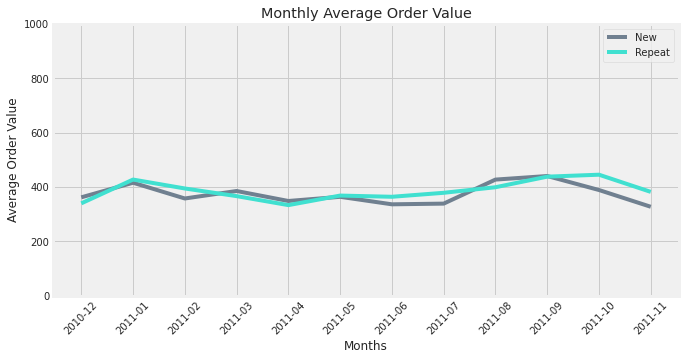

In [37]:
merged = pd.merge(df, df_cust_type, how = 'inner', on = 'InvoiceNo')

# Monthly AOV
aov = (merged.groupby(['InvoiceMonth_x','Type']).TotalPrice_x.sum().unstack() / merged.groupby(['InvoiceMonth_x','Type']).InvoiceNo.nunique().unstack())
plt.figure(figsize=(10,5))
plt.plot(aov['New'], color='slategray')
plt.plot(aov['Repeat'], color='turquoise')
plt.legend(['New', 'Repeat'])
plt.xlabel('Months')
plt.ylabel('Average Order Value')
plt.xticks(rotation = 45)
plt.title('Monthly Average Order Value')
plt.ylim(0,1000)

Overall, monthly AOV is fairly similar for new and repeat customers, though repeat customer AOV is higher towards the end of the year. Let's check with a box plot comparison.

Text(0, 0.5, 'Customer Type')

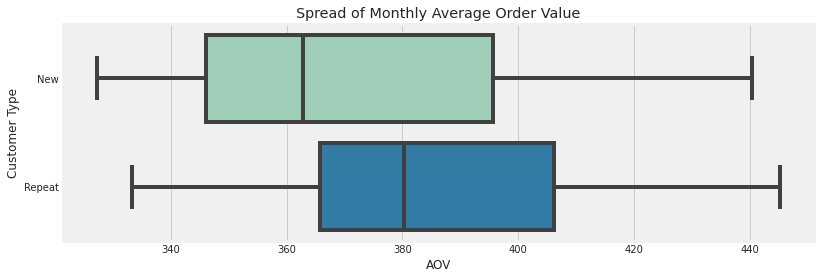

In [38]:
plt.figure(figsize=(12,4))
sns.boxplot(data=pd.melt(aov), x='value', y='Type', orient='h', palette='YlGnBu')
plt.title('Spread of Monthly Average Order Value')
plt.xlabel('AOV')
plt.ylabel('Customer Type')

Repeat customers spend more per purchase. Median monthly AOV for repeat customers is roughly 380, while that of new customers is about 365. 

### 9. Metrics

Let's create a dataframe full of juicy metrics by customer:

- Recency: days since last purchase (the lower the better)
- Frequency: number of purchases
- Monetary value: total sales
- Quantity - average and total quantity
- Average Order Value (AOV)
- 90th percentile of days between purchase
- 50th percentile of days between purchase 

While we won't use all of these metrics for the purposes here, we'll save and keep them handy for future modeling. 



In [39]:
# RFM, Quantity, AOV
snapshot_date = df.InvoiceDate.max() + timedelta(days=1)
metrics = df.groupby('CustomerID').agg({'InvoiceDate': lambda date: (snapshot_date - date.max()).days, # recency
                                        'InvoiceNo': pd.Series.nunique, # frequency
                                        'TotalPrice': 'sum', # monetary value 
                                        'Quantity':['mean','sum']}).reset_index()

metrics.columns = ['CustomerID','Recency','Frequency','Monetary_Value','Quantity_Avg','Quantity_Total']
metrics.reset_index(inplace=True, drop=True)

metrics['AOV'] = metrics['Monetary_Value'] / metrics['Frequency'] # Average Order Value (AOV)


To calculate percentiles for days between purchases by customer, we'll first identify purchase days and the time lag in days between purchases. We'll then take the 90th and 50th percentiles of the time lag for each customer. Since we're including days between purchase, we'll filter for repeat customers, that is those with a frequency greater than 1.

In [40]:
# Calculate 90th and 50th Percentile of Days between purchases 
purchase_days = df.groupby(['CustomerID','InvoiceDate']) \
                  .size() \
                  .reset_index() \
                  .rename(columns={0: 'Item_Count'})

# Time lag between purchase for each customer
purchase_days['InvoiceDate_Lagged'] = (purchase_days.sort_values(by=['InvoiceDate'], ascending=True) \
                                                    .groupby(['CustomerID'])['InvoiceDate'] \
                                                    .shift(1))

# 90th and 50th percentile between purchase days
purchase_days['90P_Days_Between_Purchase'] = purchase_days.apply(lambda x: (x.InvoiceDate - x.InvoiceDate_Lagged).days, axis=1).fillna(0)
percentile_90_purchase_days = purchase_days.groupby('CustomerID',as_index=False)['90P_Days_Between_Purchase'].quantile(0.90)
purchase_days['50P_Days_Between_Purchase'] = purchase_days.apply(lambda x: (x.InvoiceDate - x.InvoiceDate_Lagged).days, axis=1).fillna(0)
percentile_50_purchase_days = purchase_days.groupby('CustomerID',as_index=False)['50P_Days_Between_Purchase'].quantile(0.50)

metrics = pd.merge(metrics, percentile_90_purchase_days, how='inner', on='CustomerID')
metrics = pd.merge(metrics, percentile_50_purchase_days, how='inner', on='CustomerID')
metrics = metrics[metrics.Frequency > 1] # Keep only customers who made more than 1 purchase 
metrics.reset_index(inplace=True, drop=True)
metrics.head()

,CustomerID,Recency,Frequency,Monetary_Value,Quantity_Avg,Quantity_Total,AOV,90P_Days_Between_Purchase,50P_Days_Between_Purchase
0,12347,31,6,4005.29,12.128655,2074,667.548333,80.0,58.0
1,12348,67,4,826.04,42.518519,1148,206.510000,142.1,54.5
2,12352,28,7,1371.89,6.831169,526,195.984286,93.4,13.0
3,12356,14,3,2478.73,23.603448,1369,826.243333,193.6,80.0
4,12359,49,4,5362.43,6.540323,1622,1340.607500,126.9,70.5


### 10. Churn Risk

Since we're working with ecommerce data, the type of churn is voluntary, continuous, and non-contractual. 

We'll define a function to identify per-customer churn risk:

- High: days since last purchase (recency) is above the 90th percentile of days between purchases
- Medium: days since last purchase (recency) is above the 50th percentile of days between purchases
- Low: days since last purchase (recency) is below the 50th percentile of days between purchases

We'll also visualize differences among customers by churn risk. Based on customers classified as high risk of churn, we see that £828337.83 in revenue is at high risk of being lost.  

In [41]:
def churn_risk(row):
    if row['Recency'] > row['90P_Days_Between_Purchase']: return 'high'
    elif row['Recency'] > row['50P_Days_Between_Purchase']: return 'medium'
    else: return 'low'

metrics.loc[:, 'Churn_Risk'] = metrics.apply(churn_risk, axis=1)
metrics.head()

,CustomerID,Recency,Frequency,Monetary_Value,Quantity_Avg,Quantity_Total,AOV,90P_Days_Between_Purchase,50P_Days_Between_Purchase,Churn_Risk
0,12347,31,6,4005.29,12.128655,2074,667.548333,80.0,58.0,low
1,12348,67,4,826.04,42.518519,1148,206.510000,142.1,54.5,medium
2,12352,28,7,1371.89,6.831169,526,195.984286,93.4,13.0,medium
3,12356,14,3,2478.73,23.603448,1369,826.243333,193.6,80.0,low
4,12359,49,4,5362.43,6.540323,1622,1340.607500,126.9,70.5,low


Text(0, 0.5, 'Risk Level')

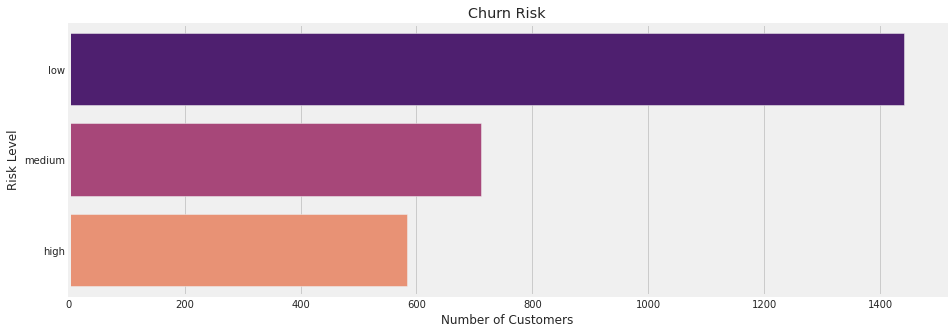

In [42]:
plt.figure(figsize=(14,5))
sns.barplot(data=metrics, x=metrics['Churn_Risk'].value_counts().sort_values(ascending=False), y=metrics['Churn_Risk'].unique(), palette='magma', orient='h')
plt.title('Churn Risk')
plt.xlabel('Number of Customers')
plt.ylabel('Risk Level')

Nearly 600 customers are at high risk of churn (beyond the 90th percentile between purhcase days).

Text(0, 0.5, 'Risk Level')

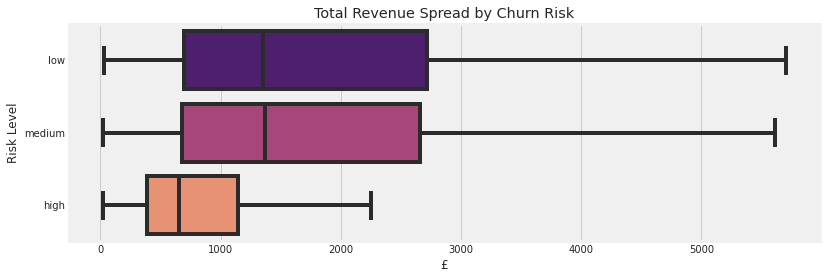

In [43]:
churn_revenue = pd.DataFrame(metrics.groupby(['CustomerID','Churn_Risk'])['Monetary_Value'].sum()).reset_index()
plt.figure(figsize=(12,4))
sns.boxplot(data=churn_revenue, x='Monetary_Value', y='Churn_Risk', orient='h', palette='magma', showfliers=False)
plt.title('Total Revenue Spread by Churn Risk')
plt.xlabel('£')
plt.ylabel('Risk Level')

High risk churn customers spend significantly less than low and medium risk churn customers. 

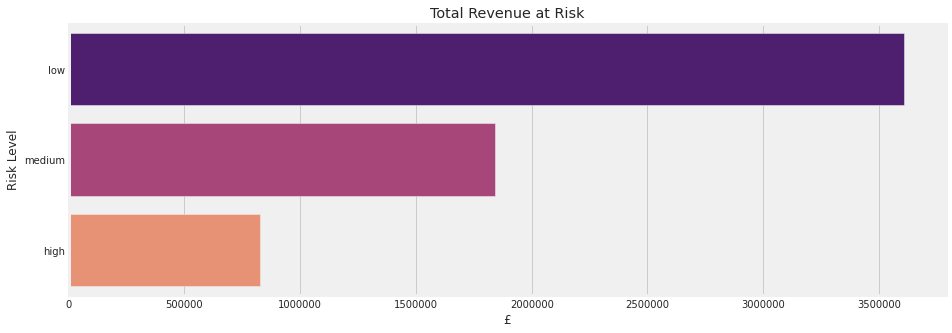

In [44]:
revenue_risk = pd.DataFrame(metrics.groupby(['Churn_Risk'])['Monetary_Value'].sum().sort_values(ascending=False))
plt.figure(figsize=(14,5))
sns.barplot(data=revenue_risk, x=revenue_risk['Monetary_Value'], y=revenue_risk.index.unique(), palette='magma', orient='h')
plt.title('Total Revenue at Risk')
plt.xlabel('£')
plt.ylabel('Risk Level')
plt.ticklabel_format(style='plain', axis='x')

In [45]:
print('Total revenue at high risk of being lost: £{:.2f}'.format(metrics[metrics.Churn_Risk=='high']['Monetary_Value'].sum()))

Total revenue at high risk of being lost: £828337.83


In [46]:
# Save metrics csv
metrics.to_csv('metrics.csv', index=False)

## 11. References

https://learn.datacamp.com/skill-tracks/marketing-analytics-with-python

https://github.com/koshika15/Predict-sales-of-an-online-retail-store/blob/master/Capstone%20Project%202_%20Final%20Report.pdf

https://github.com/abhilashsinghcad/Data-Analysis---UK-Online-Retail/blob/master/Online%20Retail%20-%20Data%20Exploration%20and%20Customer%20Metrics.ipynb

https://www.datacamp.com/community/tutorials/customer-life-time-value

https://github.com/SheikMohamed1987/Online-Retail-Store-Anomaly-Detection

https://colab.research.google.com/github/michellebonat/Predict_Customer_Churn_ML/blob/master/Predict_Customer_Churn_Case_Study.ipynb

https://github.com/mukulsinghal001/customer-lifetime-prediction-using-python/blob/main/Customer%20Lifetime%20Prediction%20Using%20Probabilistic%20Models%20-%20Midway%20Report.ipynb

https://databricks.com/notebooks/CLV_Part_1_Customer_Lifetimes.html

https://towardsdatascience.com/whats-a-customer-worth-8daf183f8a4f

https://databricks.com/notebooks/Customer%20Lifetime%20Value%20Virtual%20Workshop/02%20The%20BTYD%20Models.html